# Abnormality Detection in Musculoskeletal Radiographs

Author: Rajkumar Shanmuganathan

The objective is to build a machine learning model that can detect an abnormality in the X-Ray radiographs. These models can help towards providing healthcare access to the parts of the world where access to skilled radiologists is limited. According to a study on the Global Burden of Disease and the worldwide impact of all diseases found that, “musculoskeletal conditions affect more than 1.7 billion people worldwide. They are the 2nd greatest cause of disabilities, and have the 4th greatest impact on the overall health of the world population when considering both death and disabilities”. (www.usbji.org, n.d.).

This project attempts to implement deep neural network using DenseNet169 inspired from the Stanford Paper Rajpurkar, et al., 2018.

## Filter visualization

Referenced from the implementation of VGG convolutional filter visualization by Francois Chollet. https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html

In [9]:
"""Visualization of the filters of DenseNet, via gradient ascent in input space.
"""
from __future__ import print_function
from keras.models import Model, load_model
import time
import numpy as np
from PIL import Image as pil_image
from keras.preprocessing.image import save_img
from keras import layers
from keras import backend as K
import os
import matplotlib.pyplot as plt
from skimage import io, transform

### Define functions to normalize & process the image.

In [1]:
def normalize(x):
    """utility function to normalize a tensor.
    # Arguments
        x: An input tensor.
    # Returns
        The normalized input tensor.
    """
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())


def deprocess_image(x):
    """utility function to convert a float array into a valid uint8 image.
    # Arguments
        x: A numpy-array representing the generated image.
    # Returns
        A processed numpy-array, which could be used in e.g. imshow.
    """
    # normalize tensor: center on 0., ensure std is 0.25
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.25

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((0, 1, 2))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


def process_image(x, former):
    """utility function to convert a valid uint8 image back into a float array.
       Reverses `deprocess_image`.
    # Arguments
        x: A numpy-array, which could be used in e.g. imshow.
        former: The former numpy-array.
                Need to determine the former mean and variance.
    # Returns
        A processed numpy-array representing the generated image.
    """
    if K.image_data_format() == 'channels_first':
        x = x.transpose((2, 0, 1))
    return (x / 255 - 0.5) * 4 * former.std() + former.mean()

In [2]:
def visualize_layer(model,
                    layer_name,
                    step=1.,
                    epochs=15,
                    upscaling_steps=9,
                    upscaling_factor=1.2,
                    output_dim=(224, 224),
                    filter_range=(0, None)):
    """Visualizes the most relevant filters of one conv-layer in a certain model.
    # Arguments
        model: The model containing layer_name.
        layer_name: The name of the layer to be visualized.
                    Has to be a part of model.
        step: step size for gradient ascent.
        epochs: Number of iterations for gradient ascent.
        upscaling_steps: Number of upscaling steps.
                         Starting image is in this case (80, 80).
        upscaling_factor: Factor to which to slowly upgrade
                          the image towards output_dim.
        output_dim: [img_width, img_height] The output image dimensions.
        filter_range: Tupel[lower, upper]
                      Determines the to be computed filter numbers.
                      If the second value is `None`,
                      the last filter will be inferred as the upper boundary.
    """

    def _generate_filter_image(input_img,
                               layer_output,
                               filter_index):
        """Generates image for one particular filter.
        # Arguments
            input_img: The input-image Tensor.
            layer_output: The output-image Tensor.
            filter_index: The to be processed filter number.
                          Assumed to be valid.
        #Returns
            Either None if no image could be generated.
            or a tuple of the image (array) itself and the last loss.
        """
        s_time = time.time()

        # we build a loss function that maximizes the activation
        # of the nth filter of the layer considered
        if K.image_data_format() == 'channels_first':
            loss = K.mean(layer_output[:, filter_index, :, :])
        else:
            loss = K.mean(layer_output[:, :, :, filter_index])

        # we compute the gradient of the input picture wrt this loss
        print('(K.gradients(loss, input_img)')
        print(K.gradients(loss, input_img))
        grads = K.gradients(loss, input_img)[0]

        # normalization trick: we normalize the gradient
        grads = normalize(grads)

        # this function returns the loss and grads given the input picture
        iterate = K.function([input_img], [loss, grads])

        # we start from a gray image with some random noise
        intermediate_dim = tuple(
            int(x / (upscaling_factor ** upscaling_steps)) for x in output_dim)
        if K.image_data_format() == 'channels_first':
            input_img_data = np.random.random(
                (1, 3, intermediate_dim[0], intermediate_dim[1]))
        else:
            input_img_data = np.random.random(
                (1, intermediate_dim[0], intermediate_dim[1], 3))
        input_img_data = (input_img_data - 0.5) * 20 + 128

        # Slowly upscaling towards the original size prevents
        # a dominating high-frequency of the to visualized structure
        # as it would occur if we directly compute the 412d-image.
        # Behaves as a better starting point for each following dimension
        # and therefore avoids poor local minima
        for up in reversed(range(upscaling_steps)):
            # we run gradient ascent for e.g. 20 steps
            for _ in range(epochs):
                loss_value, grads_value = iterate([input_img_data])
                input_img_data += grads_value * step

                # some filters get stuck to 0, we can skip them
                if loss_value <= K.epsilon():
                    return None

            # Calulate upscaled dimension
            intermediate_dim = tuple(
                int(x / (upscaling_factor ** up)) for x in output_dim)
            # Upscale
            img = deprocess_image(input_img_data[0])
            print('_generate_filter_image::input_img_data')
            print(len(input_img_data))
            img = np.array(pil_image.fromarray(img).resize(intermediate_dim,
                                                           pil_image.BICUBIC))
            input_img_data = [process_image(img, input_img_data[0])]

        # decode the resulting input image
        img = deprocess_image(input_img_data[0])
        e_time = time.time()
        print('Costs of filter {:3}: {:5.0f} ( {:4.2f}s )'.format(filter_index,
                                                                  loss_value,
                                                                  e_time - s_time))
        return img, loss_value

    def _draw_filters(filters, n=None):
        """Draw the best filters in a nxn grid.
        # Arguments
            filters: A List of generated images and their corresponding losses
                     for each processed filter.
            n: dimension of the grid.
               If none, the largest possible square will be used
        """
        if(len(filters) > 0):
            if n is None:
                n = int(np.floor(np.sqrt(len(filters))))

            # the filters that have the highest loss are assumed to be better-looking.
            # we will only keep the top n*n filters.
            filters.sort(key=lambda x: x[1], reverse=True)
            filters = filters[:n * n]

            # build a black picture with enough space for
            # e.g. our 8 x 8 filters of size 412 x 412, with a 5px margin in between
            MARGIN = 5
            width = n * output_dim[0] + (n - 1) * MARGIN
            height = n * output_dim[1] + (n - 1) * MARGIN
            print('height=>'+str(height)+'width=>'+str(width))
            stitched_filters = np.zeros((width, height, 3), dtype='uint8')

            # fill the picture with our saved filters
            for i in range(n):
                for j in range(n):
                    img, _ = filters[i * n + j]
                    width_margin = (output_dim[0] + MARGIN) * i
                    height_margin = (output_dim[1] + MARGIN) * j
                    stitched_filters[
                        width_margin: width_margin + output_dim[0],
                        height_margin: height_margin + output_dim[1], :] = img

            # save the result to disk
            print("saving--->"+'cnn_{0:}_{1:}x{1:}.png'.format(layer_name, n))
            save_img('cnn_{0:}_{1:}x{1:}.png'.format(layer_name, n), stitched_filters)

    # this is the placeholder for the input images
    assert len(model.inputs) == 1
    input_img = model.inputs[0]
    output_layer = None

    # get the symbolic outputs of each "key" layer (we gave them unique names).
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
    #layer_dict = dict([(layer.name, layer) for layer in model.layers])

    try:
        output_layer = layer_dict[layer_name]
    except(KeyError) as e:
        print('I got a KeyError - reason "%s"' % str(e))

    if(output_layer is not None):

        assert isinstance(output_layer, layers.Conv2D)

        print("data from output_layer")
        print(output_layer.get_weights()[0])
        # Compute to be processed filter range
        filter_lower = filter_range[0]
        filter_upper = (filter_range[1]
                        if filter_range[1] is not None
                        else len(output_layer.get_weights()[0]))
        assert(filter_lower >= 0
               and filter_upper <= len(output_layer.get_weights()[0])
               and filter_upper > filter_lower)
        print('Compute filters {:} to {:}'.format(filter_lower, filter_upper))

        # iterate through each filter and generate its corresponding image
        processed_filters = []
        for f in range(filter_lower, filter_upper):
            img_loss = _generate_filter_image(input_img, output_layer.output, f)

            if img_loss is not None:
                processed_filters.append(img_loss)

        print('{} filter processed.'.format(len(processed_filters)))
        # Finally draw and store the best filters to disk
        _draw_filters(processed_filters)


In [ ]:
# the name of the layer we want to visualize
LAYER_NAME = ['conv2_block1_1_conv','conv2_block5_1_conv','conv2_block10_1_conv','conv2_block15_1_conv','conv2_block20_1_conv','conv2_block25_1_conv','conv2_block32_1_conv']
#LAYER_NAME = ['conv5_block32_2_conv']

# Load the Model.
model = load_model("../models/densenet_mura_rs_v3.h5")
print('Model loaded.')
model.summary()

# example function call
for layername in LAYER_NAME:
    visualize_layer(model, layername)


### Visualizing the filter images.

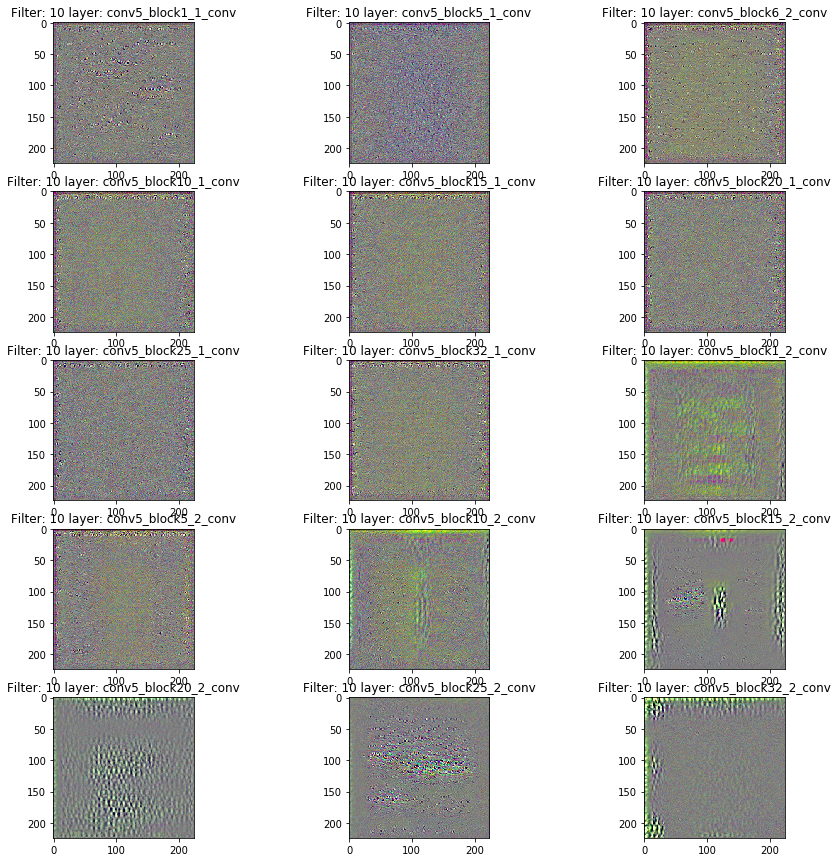

In [22]:
fig = plt.figure(1,figsize=(15,15))
filter='10'
base_path = '../images/'
layername = ['conv5_block1_1_conv','conv5_block5_1_conv','conv5_block6_2_conv','conv5_block10_1_conv','conv5_block15_1_conv','conv5_block20_1_conv','conv5_block25_1_conv','conv5_block32_1_conv','conv5_block1_2_conv','conv5_block5_2_conv','conv5_block10_2_conv','conv5_block15_2_conv','conv5_block20_2_conv','conv5_block25_2_conv','conv5_block32_2_conv']
i=0
for layer in layername:
    ax = fig.add_subplot(5,3,i+1)
    img_path = base_path+layer+"_filter_"+str(filter)+".png"
    ax.imshow(io.imread(img_path))
    cat = img_path.split('/')[2] # get the radiograph category
    plt.title('Filter: %s layer: %s' % (filter, layer))
    i = i+1
plt.show()

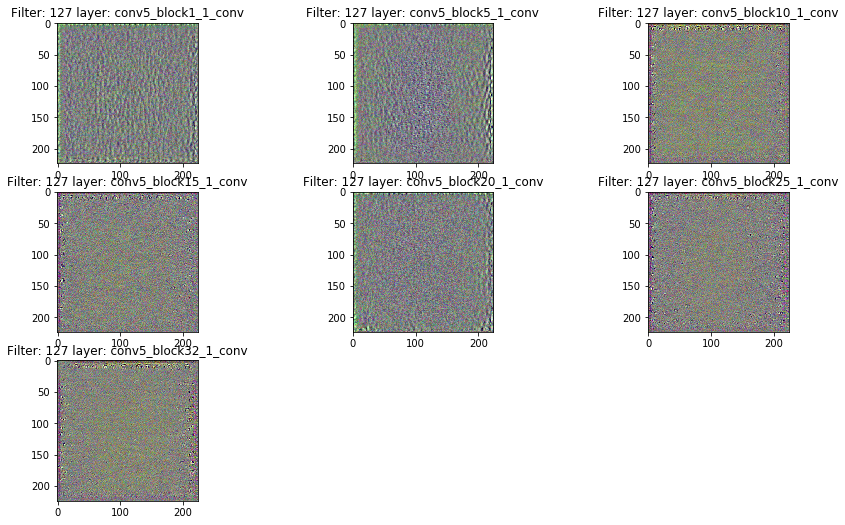

In [31]:
fig = plt.figure(1,figsize=(15,15))
filter='127'
base_path = '../images/'
layername = ['conv5_block1_1_conv','conv5_block5_1_conv','conv5_block10_1_conv','conv5_block15_1_conv','conv5_block20_1_conv','conv5_block25_1_conv','conv5_block32_1_conv']
i=0
for layer in layername:
    ax = fig.add_subplot(5,3,i+1)
    img_path = base_path+layer+"_filter_"+str(filter)+".png"
    ax.imshow(io.imread(img_path))
    cat = img_path.split('/')[2] # get the radiograph category
    plt.title('Filter: %s layer: %s' % (filter, layer))
    i = i+1
plt.show()